## MLP model taken from https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

## PyTorch internals reference http://blog.ezyang.com/2019/05/pytorch-internals/

In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read all words

words = open('names.txt', 'r').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
print(len(words))

32033


In [4]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
print(chars)
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset (do it for the first word for easy visualization)

block_size = 3 # context length: how many characters do we take to predict the next one?

X, Y = [], [] # training and label sets

for w in words[:1]:
    print('Word :', w)
    context = [0] * block_size
    print('Initial context :', context)
    for ch in (w + '.'):
        print('Character : ', ch)
        ix = stoi[ch]
        print('Index of character :', ix)
        X.append(context) 
        print('X :', X)
        Y.append(ix)
        print('Y :', Y)
        print(''.join(itos[i] for i in context), '--->', itos[ix]) # previous three characters will be used to 
                                                                   # predict the next character, padding is 
                                                                   # done by '.'
        context = context[1:] + [ix] # crop and append
        print('New context :', context)
        print('-'*100)

X = torch.tensor(X)
Y = torch.tensor(Y)

Word : emma
Initial context : [0, 0, 0]
Character :  e
Index of character : 5
X : [[0, 0, 0]]
Y : [5]
... ---> e
New context : [0, 0, 5]
----------------------------------------------------------------------------------------------------
Character :  m
Index of character : 13
X : [[0, 0, 0], [0, 0, 5]]
Y : [5, 13]
..e ---> m
New context : [0, 5, 13]
----------------------------------------------------------------------------------------------------
Character :  m
Index of character : 13
X : [[0, 0, 0], [0, 0, 5], [0, 5, 13]]
Y : [5, 13, 13]
.em ---> m
New context : [5, 13, 13]
----------------------------------------------------------------------------------------------------
Character :  a
Index of character : 1
X : [[0, 0, 0], [0, 0, 5], [0, 5, 13], [5, 13, 13]]
Y : [5, 13, 13, 1]
emm ---> a
New context : [13, 13, 1]
----------------------------------------------------------------------------------------------------
Character :  .
Index of character : 0
X : [[0, 0, 0], [0, 0, 5], [0,

In [6]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

In [7]:
Y

tensor([ 5, 13, 13,  1,  0])

In [8]:
X.shape, Y.shape

(torch.Size([5, 3]), torch.Size([5]))

In [9]:
# build the dataset for the first five words

block_size = 3 # context length: how many characters do we take to predict the next one?

X, Y = [], [] # training and label sets

for w in words[:5]:
    context = [0] * block_size
    for ch in (w + '.'):
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] 

X = torch.tensor(X)
Y = torch.tensor(Y)

In [10]:
X.shape, Y.shape 

(torch.Size([32, 3]), torch.Size([32]))

In [11]:
# implement the embedding lookup table

C = torch.randn((27, 2)) # 27 characters embedded in a 2 dimensional space
C[5] # embed a single row of C

tensor([-0.8082,  0.2362])

In [12]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.8082,  0.2362])

In [13]:
# use the lookup table C to get embeddings for X

emb = C[X]
emb

tensor([[[-0.6011,  0.4207],
         [-0.6011,  0.4207],
         [-0.6011,  0.4207]],

        [[-0.6011,  0.4207],
         [-0.6011,  0.4207],
         [-0.8082,  0.2362]],

        [[-0.6011,  0.4207],
         [-0.8082,  0.2362],
         [ 0.2685,  2.1589]],

        [[-0.8082,  0.2362],
         [ 0.2685,  2.1589],
         [ 0.2685,  2.1589]],

        [[ 0.2685,  2.1589],
         [ 0.2685,  2.1589],
         [-0.0894,  0.2521]],

        [[-0.6011,  0.4207],
         [-0.6011,  0.4207],
         [-0.6011,  0.4207]],

        [[-0.6011,  0.4207],
         [-0.6011,  0.4207],
         [ 0.7075, -0.5021]],

        [[-0.6011,  0.4207],
         [ 0.7075, -0.5021],
         [ 1.1054, -0.7344]],

        [[ 0.7075, -0.5021],
         [ 1.1054, -0.7344],
         [-0.3307,  1.2246]],

        [[ 1.1054, -0.7344],
         [-0.3307,  1.2246],
         [ 1.0669,  0.3624]],

        [[-0.3307,  1.2246],
         [ 1.0669,  0.3624],
         [-0.3307,  1.2246]],

        [[ 1.0669,  0

In [14]:
emb.shape

torch.Size([32, 3, 2])

In [15]:
# for example to find embedding of X[13,2] we can do C[X][13,2]

print(X[13,2])
print(C[X][13,2]) # also equal to C[1]

tensor(1)
tensor([-0.0894,  0.2521])


In [16]:
emb.view(-1,6) # change embeddings to a 2D tensor 
               # (does not create new memory)

tensor([[-0.6011,  0.4207, -0.6011,  0.4207, -0.6011,  0.4207],
        [-0.6011,  0.4207, -0.6011,  0.4207, -0.8082,  0.2362],
        [-0.6011,  0.4207, -0.8082,  0.2362,  0.2685,  2.1589],
        [-0.8082,  0.2362,  0.2685,  2.1589,  0.2685,  2.1589],
        [ 0.2685,  2.1589,  0.2685,  2.1589, -0.0894,  0.2521],
        [-0.6011,  0.4207, -0.6011,  0.4207, -0.6011,  0.4207],
        [-0.6011,  0.4207, -0.6011,  0.4207,  0.7075, -0.5021],
        [-0.6011,  0.4207,  0.7075, -0.5021,  1.1054, -0.7344],
        [ 0.7075, -0.5021,  1.1054, -0.7344, -0.3307,  1.2246],
        [ 1.1054, -0.7344, -0.3307,  1.2246,  1.0669,  0.3624],
        [-0.3307,  1.2246,  1.0669,  0.3624, -0.3307,  1.2246],
        [ 1.0669,  0.3624, -0.3307,  1.2246, -0.0894,  0.2521],
        [-0.6011,  0.4207, -0.6011,  0.4207, -0.6011,  0.4207],
        [-0.6011,  0.4207, -0.6011,  0.4207, -0.0894,  0.2521],
        [-0.6011,  0.4207, -0.0894,  0.2521,  1.0669,  0.3624],
        [-0.0894,  0.2521,  1.0669,  0.3

In [17]:
# initialize weights and biases for the hiddden layer

W1 = torch.randn((6,100)) # randomly initialized weights 
                          # number of inputs is 6 and
                          # number of neurons is say 100
b1 = torch.randn(100) # randomly initialized biases

In [18]:
# implement the first hidden layer of activations 
# tanh nonlinearity squashes the numbers between -1 and 1

h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[-0.8098, -0.4951,  0.6185,  ..., -0.8257,  0.4611,  0.8650],
        [-0.7743, -0.3123,  0.6011,  ..., -0.8702,  0.4233,  0.8278],
        [-0.9932, -0.8750,  0.4769,  ..., -0.7163,  0.5452,  0.9986],
        ...,
        [-0.9698,  0.9960, -0.9781,  ..., -0.9987, -0.3191,  0.7868],
        [-0.9998,  0.9954,  0.2704,  ..., -0.9998, -0.9139,  0.9994],
        [ 0.8643, -0.7155,  0.9893,  ..., -0.9945, -0.7578, -0.3303]])

In [19]:
h.shape

torch.Size([32, 100])

In [20]:
# initialize weights and biases for the output layer

W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [21]:
# calculate logits for the output layer

logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [22]:
# calculate probabilities and implement negative log likelihood loss

counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs.shape

torch.Size([32, 27])

In [23]:
# get probabilities for the labels Y

probs[torch.arange(Y.shape[0]), Y]

tensor([7.1374e-09, 8.7466e-09, 4.0027e-10, 7.7420e-04, 5.6128e-06, 2.7402e-09,
        7.2938e-07, 2.2827e-08, 3.5035e-01, 4.7783e-03, 9.9833e-01, 1.2345e-09,
        1.0687e-12, 7.1909e-12, 8.8042e-08, 2.3273e-05, 6.3567e-15, 2.3009e-05,
        9.4208e-12, 6.0705e-09, 7.1674e-05, 5.8649e-08, 4.7915e-11, 3.4125e-08,
        1.9378e-08, 2.0847e-04, 1.1465e-06, 2.9717e-09, 7.6963e-05, 2.0515e-07,
        1.0231e-03, 5.6432e-06])

In [24]:
# calculate negative log likelihood loss (we want to minimize this
# loss by training the neural network) 

loss = -probs[torch.arange(Y.shape[0]), Y].log().mean()
loss

tensor(15.4658)

In [55]:
# ------------Summary of the neural network---------------

In [26]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [27]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [28]:
sum(p.nelement() for p in parameters) # total number of parameters

3481

In [29]:
for p in parameters:
    p.requires_grad = True

In [30]:
# forward pass

for _ in range(1000):
    
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y) # should use this, more efficient
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

0.2561391294002533


In [40]:
# Build training, validation and test sets from the entire data

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?

    X, Y = [], [] # training and label sets

    for w in words:
        context = [0] * block_size
        for ch in (w + '.'):
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] 

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    
    return X, Y

In [42]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [43]:
len(words)

32033

In [44]:
n1 # number of words in the training test

25626

In [45]:
n2 - n1 # number of words in the validation set

3203

In [46]:
len(words) - n2 # number of words in the test set

3204

In [47]:
# increase the embedding size and number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [48]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [49]:
for p in parameters:
    p.requires_grad = True

In [50]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [52]:
lri = []
lossi = []
stepi = []

In [56]:
for i in range(200000):
    
    # construct minibatch of 32 samples
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

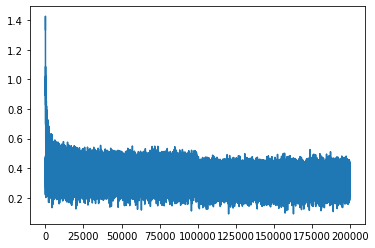

In [58]:
plt.plot(stepi, lossi) # the loss is dense because of minibatches

In [59]:
# calculate training loss

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0784, grad_fn=<NllLossBackward>)

In [60]:
# calculate validation loss

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1443, grad_fn=<NllLossBackward>)

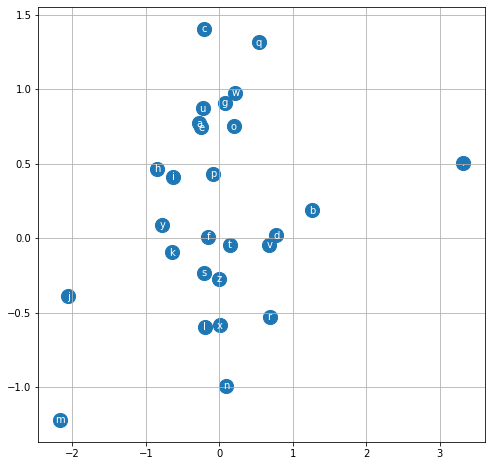

In [61]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [62]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [76]:
# sample one name from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(1):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        print('Context indices:', context)
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        print('Output indices:', out)
        if ix == 0:
            break
            
    print('\n')
    print('Sampled name:', ''.join(itos[i] for i in out))

Context indices: [0, 0, 0]
Output indices: [3]
Context indices: [0, 0, 3]
Output indices: [3, 1]
Context indices: [0, 3, 1]
Output indices: [3, 1, 18]
Context indices: [3, 1, 18]
Output indices: [3, 1, 18, 13]
Context indices: [1, 18, 13]
Output indices: [3, 1, 18, 13, 1]
Context indices: [18, 13, 1]
Output indices: [3, 1, 18, 13, 1, 8]
Context indices: [13, 1, 8]
Output indices: [3, 1, 18, 13, 1, 8, 26]
Context indices: [1, 8, 26]
Output indices: [3, 1, 18, 13, 1, 8, 26, 1]
Context indices: [8, 26, 1]
Output indices: [3, 1, 18, 13, 1, 8, 26, 1, 0]


Sampled name: carmahza.


In [80]:
# sample ten names from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmahza.
jahmer.
kimri.
rehty.
halayane.
rahnee.
delynn.
jareeius.
kasia.
chaiiv.
